In [14]:

# Force CPU backend on Apple Silicon to avoid Metal issues
# os.environ["JAX_PLATFORMS"] = "cpu"
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
# Disable LaTeX rendering in matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ["DejaVu Serif"],
})

import pickle

import jax.numpy as jnp
from jax import random
from sbijax import NLE, plot_loss_profile
from sbijax.nn import make_maf

from vr_foraging_sbi_ddm.simulator import JaxPatchForagingDdm, create_prior
from vr_foraging_sbi_ddm.snle.snle_inference_jax import infer_parameters_snle, train_snle
from vr_foraging_sbi_ddm.snle.snle_utils_jax import extract_samples, get_model_directory, pairplot, plot_real_synth_hist
from vr_foraging_sbi_ddm.validation import (
    compute_sbc_metrics,
    plot_recovery_scatter,
    plot_sbc_diagnostics,
    validate_parameter_recovery,
)


# Configuration

In [ ]:
from vr_foraging_sbi_ddm.models import Config

CONFIG = Config(n_simulations=500000, batch_size=256, n_iter=100000, n_early_stopping_patience=20, force_retrain=True)
print("Configuration loaded")
print(f"Model directory: {CONFIG.filename}")

Configuration loaded
Model directory: []


In [ ]:
# ============================================================================
# STEP 1: Initialize and Train
# ============================================================================

simulator = JaxPatchForagingDdm(
    initial_prob=0.8,
    depletion_rate=-0.1,
    threshold=1.0,
    start_point=0.0,
    interval_min=CONFIG.interval_min,
    interval_scale=CONFIG.interval_scale,
    interval_normalization=CONFIG.interval_normalization,
    odor_site_length=CONFIG.odor_site_length,
    max_sites_per_window=CONFIG.window_size,
    n_feat=CONFIG.n_feat,
)

prior_fn = create_prior(prior_low=jnp.array(CONFIG.prior_low), prior_high=jnp.array(CONFIG.prior_high))

print("Simulator initialized")

# Create model directory and get checkpoint directory
model_dir, checkpoint_dir = get_model_directory(CONFIG)
model_path = model_dir / "model.pkl"

print(f"Model directory: {model_dir}")
print(f"Model file: {model_path}")

if model_path.exists() and not CONFIG.force_retrain:
    print(f"Loading existing model from {model_path}")
    with open(model_path, "rb") as f:
        model_data = pickle.load(f)
    snle = model_data["snle"]
    snle_params = model_data["snle_params"]
    y_mean = model_data["y_mean"]
    y_std = model_data["y_std"]
    print("Model loaded successfully")
else:
    print("Training new SNLE model...")
    print(f"Config: {CONFIG}")

    rng_key = random.PRNGKey(CONFIG.seed)

    snle, snle_params, losses, rng_key, y_mean, y_std = train_snle(
        simulator,
        prior_fn,
        n_simulations=CONFIG.n_simulations,
        hidden_dim=CONFIG.hidden_dim,
        num_layers=CONFIG.num_layers,
        n_iter=CONFIG.n_iter,
        batch_size=CONFIG.batch_size,
        n_early_stopping_patience=CONFIG.n_early_stopping_patience,
        learning_rate=CONFIG.learning_rate,
        transition_steps=CONFIG.transition_steps,
        decay_rate=CONFIG.decay_rate,
        percentage_data_as_validation_set=0.1,
        rng_key=rng_key,
        save_dir=str(checkpoint_dir),
    )

    # Save final model with descriptive filename
    print(f"\nSaving final model to {model_path}")
    model_data = {
        "snle_params": snle_params,
        "losses": losses,
        "y_mean": y_mean,
        "y_std": y_std,
        "config": CONFIG,
        "model_dir": str(model_dir),
        "checkpoint_dir": str(checkpoint_dir),
    }

with open(model_path, "wb") as f:
    pickle.dump(model_data, f)

    print(f"Model saved successfully to {model_path}")
    print(f"Checkpoints saved in {checkpoint_dir}")

print("\n" + "=" * 80)
print("Training complete!")
print(f"Model directory: {model_dir}")
print("=" * 80)

In [17]:
# Save with descriptive filename
print(f"\nSaving model to {model_path}")
model_data = {
    "snle_params": snle_params,
    "losses": losses,
    "y_mean": y_mean,
    "y_std": y_std,
    "config": CONFIG.model_dump(),
}

with open(model_path, "wb") as f:
    pickle.dump(model_data, f)

print("✓ Model saved successfully")


Saving model to results/snle_500K_lr0.001_ts5000_h128_l8_b256_37feat/model.pkl
✓ Model saved successfully


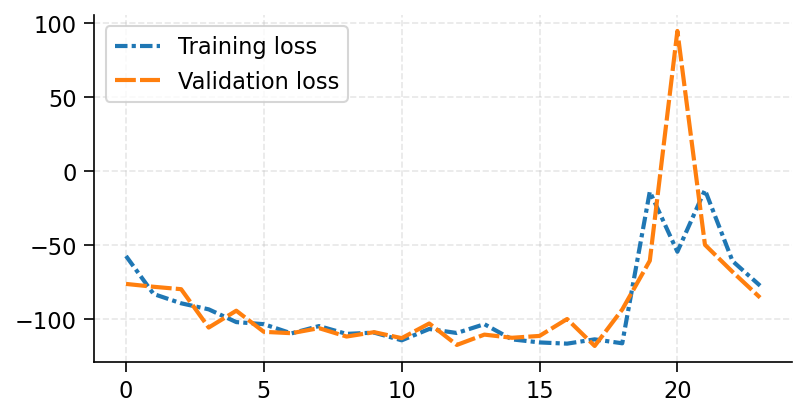

In [18]:
model_path = "results/snle_500K_lr0.001_ts5000_h128_l8_b256_37feat/model.pkl"

with open(model_path, "rb") as f:
    model_data = pickle.load(f)

from vr_foraging_sbi_ddm.plot_utils import a_lot_of_style
with a_lot_of_style():
    _, axes = plt.subplots(figsize=(6, 3))
    plot_loss_profile(model_data["losses"], axes)
    #axes.set_ylim([-300, 100])
    plt.show()

In [ ]:
CONFIG = Config.model_validate(model_data["config"])
#with open(model_path, "rb") as f:
#    model_data = pickle.load(f)

# Reconstruct SNLE
simulator = JaxPatchForagingDdm(max_sites_per_window=100, n_feat=CONFIG.n_feat)
prior_fn = create_prior(prior_low=jnp.array(CONFIG.prior_low), prior_high=jnp.array(CONFIG.prior_high))

rng_key = random.PRNGKey(CONFIG.seed)
rng_key, test_key = random.split(rng_key)
test_theta = prior_fn().sample(seed=test_key)
test_x = simulator.simulator_fn(seed=test_key, theta=test_theta)
n_features = test_x.shape[-1]

flow = make_maf(
    n_dimension=n_features,  # obs data dimension
    n_layers=CONFIG.num_layers,
    hidden_sizes=(CONFIG.hidden_dim, CONFIG.hidden_dim),
)

snle = NLE((prior_fn, simulator.simulator_fn), flow)

print("✓ Model loaded!")

In [ ]:
# --- Simulate observed data ---
print("\n2. Simulating observed data...")
rng_key, subkey = random.split(rng_key)
true_theta = prior_fn().sample(seed=subkey)["theta"]
rng_key, subkey = random.split(rng_key)
_, observed_stats = simulator.simulate_one_window(true_theta, subkey)
print(f"   True theta: {true_theta}")
print(f"   Observed stats: {observed_stats}")

In [ ]:
# --- Run inference ---
print("\n3. Testing inference...")
rng_key, subkey = random.split(rng_key)
posterior_samples, diagnostics = infer_parameters_snle(
    snle,
    model_data["snle_params"],
    observed_stats,
    model_data["y_mean"],
    model_data["y_std"],
    num_samples=1_000,
    num_warmup=500,
    num_chains=4,
    rng_key=subkey,
    verbose=True,
)

In [ ]:

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ["DejaVu Serif"],
})

# --- Plot posterior distributions ---
param_names = ["drift_rate", "reward_bump", "failure_bump", "noise_std"]
param_labels = [
    "drift_rate: evidence accumulation rate",
    "reward_bump: evidence drop from receiving reward",
    "failure_bump: evidence boost from not receiving reward",
    "noise_std: std of noise in evidence accumulation",
]

fig, axes = plt.subplots(1, 4, figsize=(10, 2))
axes = axes.flatten()

for i in range(4):
    # Compute histogram
    counts, bins, _ = axes[i].hist(posterior_samples[:, i], bins=30, color="dodgerblue", edgecolor=None, alpha=0.7)

    # Posterior mode (bin center with max count)
    mode_index = jnp.argmax(counts)
    posterior_mode = (bins[mode_index] + bins[mode_index + 1]) / 2

    axes[i].axvline(true_theta[i], color="orangered", linestyle="--", label="true value")
    axes[i].axvline(posterior_mode, color="k", linestyle="--", label="MAP estimate")

    axes[i].set_xlabel(param_names[i])
    axes[i].set_xlim(CONFIG.prior_low[i], CONFIG.prior_high[i])
    axes[i].set_ylabel("Frequency")

axes[i].legend(loc="center left", bbox_to_anchor=(1, 0.5))

plt.tight_layout()

pairplot(posterior_samples, true_theta, param_names, figsize_per_param=2.0)
plt.show()



In [ ]:
import time

# ============================================================================
# VALIDATION: Parameter Recovery and SBC
# ============================================================================
# Note: Each test runs MCMC sampling which can take 30s-2min per test
# For faster iteration during development, reduce n_tests to 3-5
# For publication-quality validation, use n_tests >= 100 for SBC

# Validation - Parameter Recovery
print("=" * 80)
print("PARAMETER RECOVERY VALIDATION")
print("=" * 80)
start_time = time.time()

results = validate_parameter_recovery(
    snle, snle_params, y_mean, y_std, simulator, prior_fn, infer_parameters_snle, 
    n_tests=5,  # Originally 10
    num_samples=1000,
    num_warmup=500,
    num_chains=4,
)
plot_recovery_scatter(results, save_path="recovery_results.png")

recovery_time = time.time() - start_time
print(f"\n✓ Parameter recovery completed in {recovery_time:.2f} seconds ({recovery_time/60:.2f} minutes)")

# Full SBC - Compute metrics and plot diagnostics
print("\n" + "=" * 80)
print("SIMULATION-BASED CALIBRATION (SBC)")
print("=" * 80)
start_time = time.time()

sbc_results = compute_sbc_metrics(
    snle,
    snle_params,
    y_mean,
    y_std,
    simulator,
    prior_fn,
    infer_parameters_snle,
    n_tests=20,  # Originally 100
    num_samples=500,
    num_warmup=100,
    num_chains=2,
)
plot_sbc_diagnostics(sbc_results, bins=10, save_path="sbc_results.png")

sbc_time = time.time() - start_time
print(f"\n✓ SBC completed in {sbc_time:.2f} seconds ({sbc_time/60:.2f} minutes)")

print(f"\n{'=' * 80}")
print(f"TOTAL VALIDATION TIME: {recovery_time + sbc_time:.2f} seconds ({(recovery_time + sbc_time)/60:.2f} minutes)")
print(f"{'=' * 80}")

In [ ]:
# Generate multiple patches from posterior samples to compare distributions
print("\nGenerating patches from posterior samples for comparison...")
num_window_sites = 500

# --- Simulate 'real' data from simulator---
print("\n2. Simulating observed data...")
real_data = []
for i_site in range(num_window_sites):
    rng_key, subkey = random.split(rng_key)
    _, data = simulator.simulate_one_window(true_theta, subkey)
    real_data.append(data)
real_data = np.array(real_data)

# # 2. Generate "synthetic" data from simulator using posterior-sampled parameters
# Get observed summary stats
rng_key, subkey = random.split(rng_key)
_, observed_stats = simulator.simulate_one_window(true_theta, subkey)
obs_norm = (observed_stats - y_mean) / y_std

# Sample posterior θ using ONE observation
rng_key, sub = random.split(rng_key)
inference_results, diagnostics = snle.sample_posterior(
    sub,
    snle_params,
    observable=obs_norm,
    n_samples=500,
    n_chains=1,
    n_warmup=200,
)

posterior_ds = extract_samples(inference_results)
theta_samples = posterior_ds["theta"].values.reshape(-1, 4)  # shape (500,4)

# Simulate synthetic patches for comparison
posterior_mean_theta = theta_samples.mean(axis=0)  # Single point estimate

synthetic_data = []
for i in range(500):
    rng_key, subkey = random.split(rng_key)
    _, data = simulator.simulate_one_window(posterior_mean_theta, subkey)
    synthetic_data.append(data)
synthetic_data = jnp.array(synthetic_data)

# 4. Plot
plot_real_synth_hist(real_data, synthetic_data)